## Imports

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds

tf.get_logger().setLevel('ERROR')

## Loading the data

In [20]:
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
data_file = tf.keras.utils.get_file("breast_cancer.csv", DATASET_URL)
col_names = ["id", "clump_thickness", "un_cell_size", "un_cell_shape", "marginal_adheshion", "single_eph_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses", "class"]
df = pd.read_csv(data_file, names=col_names, header=None)

In [21]:
df.head()

,id,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


## Preprocessing the data

In [22]:
df.pop("id")

,id
0,1000025
1,1002945
2,1015425
3,1016277
4,1017023
...,...
694,776715
695,841769
696,888820
697,897471


In [23]:
df.shape

(699, 10)

In [24]:
df.dtypes

,0
clump_thickness,int64
un_cell_size,int64
un_cell_shape,int64
marginal_adheshion,int64
single_eph_cell_size,int64
bare_nuclei,object
bland_chromatin,int64
normal_nucleoli,int64
mitoses,int64
class,int64


In [25]:
df.isnull().sum()

,0
clump_thickness,0
un_cell_size,0
un_cell_shape,0
marginal_adheshion,0
single_eph_cell_size,0
bare_nuclei,0
bland_chromatin,0
normal_nucleoli,0
mitoses,0
class,0


In [26]:
df['bare_nuclei'].value_counts()

,count
bare_nuclei,
1,402
10,132
2,30
5,30
3,28
8,21
4,19
?,16
9,9


In [27]:
df = df[df["bare_nuclei"] != '?' ]
df.bare_nuclei = pd.to_numeric(df.bare_nuclei)

<ipython-input-27-20cbe26a5d65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bare_nuclei = pd.to_numeric(df.bare_nuclei)


In [28]:
df.shape

(683, 10)

<Axes: >

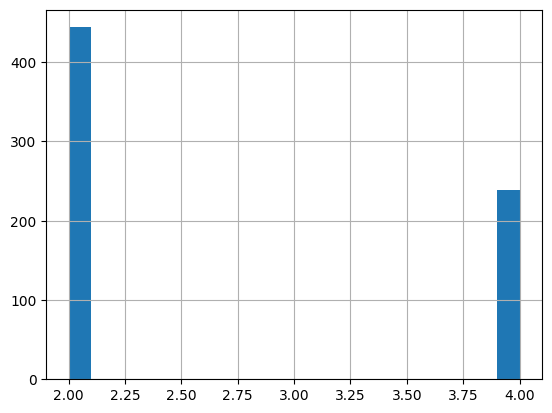

In [34]:
df['class'].hist(bins=20)

In [35]:
df['class'] = np.where(df['class'] == 2, 0, 1)

## Spltting the data into train and test sets and preparing the data

In [36]:
train, test = train_test_split(df, test_size = 0.2)

In [37]:
train_stats = train.describe()
train_stats.pop('class')
train_stats = train_stats.transpose()

train_Y = train.pop("class")
test_Y = test.pop("class")

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

norm_train_X = norm(train)
norm_test_X = norm(test)

In [38]:
train_dataset = tf.data.Dataset.from_tensor_slices((norm_train_X.values, train_Y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((norm_test_X.values, test_Y.values))

In [39]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train)).batch(batch_size)

test_dataset =  test_dataset.batch(batch_size=batch_size)

In [40]:
a = enumerate(train_dataset)

print(len(list(a)))

18


## Creating and initializing the model

In [42]:
def base_model():
    inputs = tf.keras.layers.Input(shape=(len(train.columns),))
    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = base_model()

## Setting up the optimizer and loss object

In [43]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

## Evaluating the untrained model

In [44]:
outputs = model(norm_test_X.values)
loss_value = loss_object(y_true=test_Y.values, y_pred=outputs)
print("Loss before training %.4f" % loss_value.numpy())

Loss before training 0.7106


In [45]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

<ipython-input-45-b043df30f57b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-45-b043df30f57b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


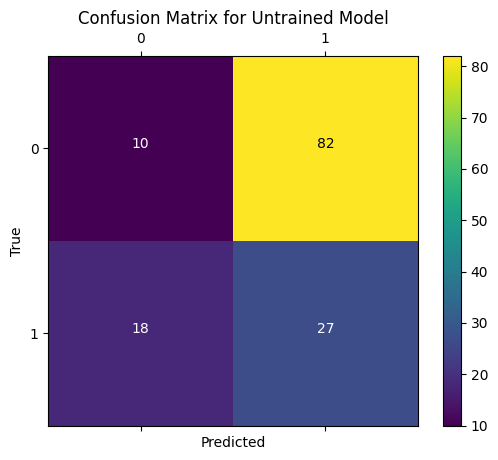

In [46]:
plot_confusion_matrix(test_Y.values, tf.round(outputs), title='Confusion Matrix for Untrained Model')

## Creating Custom F1 Score Metric for the Model


In [47]:
class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        '''initializes attributes of the class'''

        # call the parent class init
        super(F1Score, self).__init__(name=name, **kwargs)

        # Initialize Required variables
        # true positives
        self.tp = tf.Variable(0, dtype = 'int32')
        # false positives
        self.fp = tf.Variable(0, dtype = 'int32')
        # true negatives
        self.tn = tf.Variable(0, dtype = 'int32')
        # false negatives
        self.fn = tf.Variable(0, dtype = 'int32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Accumulates statistics for the metric

        Args:
            y_true: target values from the test data
            y_pred: predicted values by the model
        '''

        # Calulcate confusion matrix.
        conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)

        # Update values of true positives, true negatives, false positives and false negatives from confusion matrix.
        self.tn.assign_add(conf_matrix[0][0])
        self.tp.assign_add(conf_matrix[1][1])
        self.fp.assign_add(conf_matrix[0][1])
        self.fn.assign_add(conf_matrix[1][0])

    def result(self):
        '''Computes and returns the metric value tensor.'''

        # Calculate precision
        if (self.tp + self.fp == 0):
            precision = 1.0
        else:
            precision = self.tp / (self.tp + self.fp)

        # Calculate recall
        if (self.tp + self.fn == 0):
            recall = 1.0
        else:
            recall = self.tp / (self.tp + self.fn)

        # Return F1 Score
        f1_score =  2 * ((precision * recall) / (precision + recall))

        return f1_score

    def reset_states(self):
        '''Resets all of the metric state variables.'''

        # The state of the metric will be reset at the start of each epoch.
        self.tp.assign(0)
        self.tn.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

### Instantiate separate custom metrics for training and validation

In [48]:
train_f1score_metric = F1Score()
val_f1score_metric = F1Score()

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

## Apply Gradients

In [50]:
def apply_gradient(optimizer, loss_object, model, x, y):
    '''
    applies the gradients to the trainable model weights

    Args:
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        x: input data to the model
        y: target values for each input
    '''

    with tf.GradientTape() as tape:
      logits = model(x)
      loss_value = loss_object(y_true=y, y_pred=logits)

    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    return logits, loss_value

## Training Loop

In [51]:
def train_data_for_one_epoch(train_dataset, optimizer, loss_object, model,
                             train_acc_metric, train_f1score_metric, verbose=True):
    '''
    Computes the loss then updates the weights and metrics for one epoch.

    Args:
        train_dataset: the training dataset
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        train_acc_metric: calculates how often predictions match labels
        train_f1score_metric: custom metric we defined earlier
    '''
    losses = []

    #Iterate through all batches of training data
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        #Calculate loss and update trainable variables using optimizer
        logits, loss_value = apply_gradient(optimizer, loss_object, model, x_batch_train, y_batch_train)
        losses.append(loss_value)

        #Round off logits to nearest integer and cast to integer for calulating metrics
        logits = tf.round(logits)
        logits = tf.cast(logits, 'int64')

        #Update the training metrics

        train_acc_metric.update_state(y_batch_train, logits)
        train_f1score_metric.update_state(y_batch_train, logits)

        #Update progress
        if verbose:
            print("Training loss for step %s: %.4f" % (int(step), float(loss_value)))

    return losses

In [52]:
def perform_validation():
    losses = []

    #Iterate through all batches of validation data.
    for x_val, y_val in test_dataset:

        #Calculate validation loss for current batch.
        val_logits = model(x_val)
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)

        #Round off and cast outputs to either  or 1
        val_logits = tf.cast(tf.round(model(x_val)), 'int64')

        #Update validation metrics
        val_acc_metric.update_state(y_val, val_logits)
        val_f1score_metric.update_state(y_val, val_logits)

    return losses

In [54]:
# Iterate over epochs.
epochs = 5
epochs_val_losses, epochs_train_losses = [], []

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    #Perform Training over all batches of train data
    losses_train = train_data_for_one_epoch(train_dataset, optimizer, loss_object, model, train_acc_metric, train_f1score_metric)

    # Get results from training metrics
    train_acc = train_acc_metric.result()
    train_f1score = train_f1score_metric.result()

    #Perform validation on all batches of test data
    losses_val = perform_validation()

    # Get results from validation metrics
    val_acc = val_acc_metric.result()
    val_f1score = val_f1score_metric.result()

    #Calculate training and validation losses for current epoch
    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)

    print('\n Epcoh %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f, Train F1 Score: %.4f, Validation F1 Score: %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc), train_f1score, val_f1score))

    #Reset states of all metrics
    train_acc_metric.reset_state()
    val_acc_metric.reset_state()
    val_f1score_metric.reset_state()
    train_f1score_metric.reset_state()

Start of epoch 0
Training loss for step 0: 0.1209
Training loss for step 1: 0.0831
Training loss for step 2: 0.1199
Training loss for step 3: 0.0832
Training loss for step 4: 0.1677
Training loss for step 5: 0.0660
Training loss for step 6: 0.0679
Training loss for step 7: 0.0515
Training loss for step 8: 0.1111
Training loss for step 9: 0.0418
Training loss for step 10: 0.1139
Training loss for step 11: 0.0433
Training loss for step 12: 0.0500
Training loss for step 13: 0.0420
Training loss for step 14: 0.1367
Training loss for step 15: 0.1366
Training loss for step 16: 0.0382
Training loss for step 17: 0.0093

 Epcoh 0: Train loss: 0.0824  Validation Loss: 0.1611, Train Accuracy: 0.9560, Validation Accuracy 0.9197, Train F1 Score: 0.9397, Validation F1 Score: 0.8817
Start of epoch 1
Training loss for step 0: 0.0651
Training loss for step 1: 0.0348
Training loss for step 2: 0.0823
Training loss for step 3: 0.0691
Training loss for step 4: 0.0372
Training loss for step 5: 0.0133
Traini

## Evaluating the trained Model

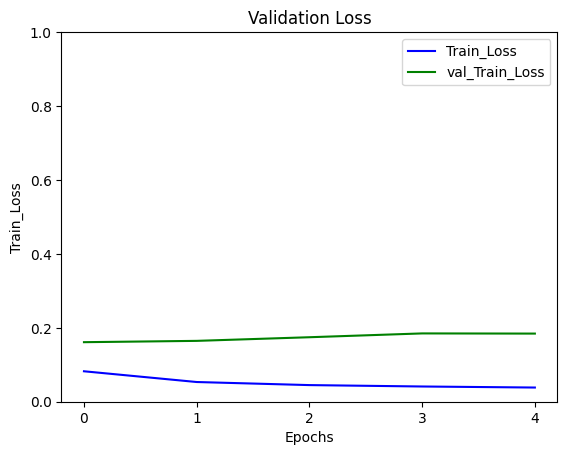

In [60]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric, color='blue', label=metric_name)
    plt.plot(val_metric, color='green', label='val_' + metric_name)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.show()


plot_metrics(epochs_train_losses, epochs_val_losses, "Train_Loss", "Validation Loss", ylim=1.0)

<ipython-input-45-b043df30f57b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-45-b043df30f57b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


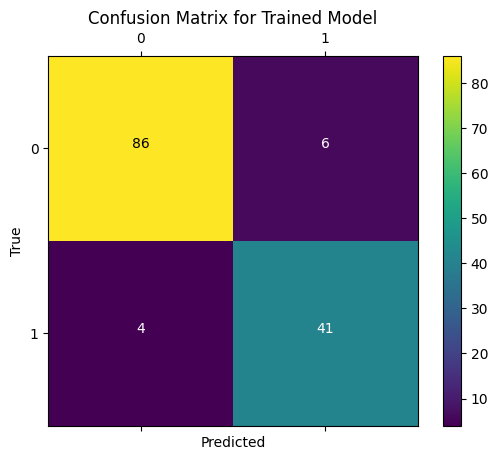

In [59]:
test_outputs = model(norm_test_X.values)
plot_confusion_matrix(test_Y.values, tf.round(test_outputs), title='Confusion Matrix for Trained Model')

### High numbers on the diagonal indicate the model is perfoming very well